# Talk Like IDEO: similarity scores

In [1]:
# Jupyter magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
import pandas as pd
import pathlib
import spacy
import collections
from textblob import TextBlob
import gensim
import matplotlib
import numpy as np
import string
import matplotlib.pyplot as plt
from gensim.corpora.textcorpus import TextCorpus

In [3]:
# import nltk
# nltk.download('stopwords')  # run once
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterwinter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import seaborn as sns

## Load IDEO docs

These were mentioned by Kathy in the [brief](https://docs.google.com/document/d/1ncZfFND1ytnZ3kgMl8RC4GtBFkC3-tAlBDQxuFhRgAU/edit). I manually copied and pasted the text into dropbox to make some quick data.

In [5]:
def read_dir_text_files(data_dir, verbose=True):

    skiplist = ['.DS_Store', "index.txt"]

#     articles = {}
    titles = []
    texts = []
    p = pathlib.Path(data_dir)
    for article_path in p.glob('*'):
        if article_path.is_dir():
            continue
        name = article_path.name
        if name in skiplist:
            continue
        txt = article_path.read_text()
        titles.append(name)
        texts.append(txt)
    if verbose:
        print(f"{len(texts)} docs found in {data_dir}")
    return titles, texts


# set the path
ideo_path = '../1_data/IDEO_journal'

# read all the files
ideo_titles, ideo_docs = read_dir_text_files(ideo_path)

# combine into one big text block
ideo_journal_single_big_text = "\n".join(ideo_docs)

# preprocess into tokens
ideo_doc_tokens = gensim.utils.simple_preprocess(ideo_journal_single_big_text)


35 docs found in ../1_data/IDEO_journal


## Load & Preprocess all the documents

So far it's just get their text and tokenize it

also save the titles and directories of the docs (for later)

In [6]:
def add_files_from_dir(paths, verbose=True):

    all_titles, all_docs, all_paths = [], [], []
    for p in paths:
        titles, docs = read_dir_text_files(p, verbose=verbose)
        all_titles += titles
        all_docs += docs
        all_paths +=  ([p.split('/')[-2]] * len(docs)) # repeates the name of the directory for each item
        
    return all_titles, all_docs, all_paths

# grab all the files from these directories and make some tokens
input_paths = [
        "../1_data/how_i_built_this/",
        "../1_data/example_articles/",
        ]

titles, docs, paths = add_files_from_dir(input_paths)
tokens = [gensim.utils.simple_preprocess(doc) for doc in docs]


60 docs found in ../1_data/how_i_built_this/
6 docs found in ../1_data/example_articles/


In [7]:
df_index = pd.DataFrame([titles, paths], index=['titles', 'dir']).T
df_index

,titles,dir
0,How I Built Resilience: Brian Chesky of Airbnb...,how_i_built_this
1,The Laundress: Lindsey Boyd.txt',how_i_built_this
2,Supergoop!: Holly Thaggard.txt',how_i_built_this
3,How I Built Resilience: Bert and John Jacobs o...,how_i_built_this
4,How I Built Resilience: Pokimane.txt',how_i_built_this
...,...,...
61,orbia_2019_howtolead,example_articles
62,orbia_2018_reuters_businessnews,example_articles
63,orbia_2019_quartzatwork,example_articles
64,marvin_2017_pressrelease.txt,example_articles


In [14]:
df_index['dir'].value_counts()

how_i_built_this    60
example_articles     6
Name: dir, dtype: int64

## Make gensim dictionary

gensim object that lets us do doc2bow functions.

Keeps track of tokens + ids for each token.



In [8]:
# Could combine
full_dictionary = gensim.corpora.Dictionary([ideo_doc_tokens])
# Right now this is just the ideo words... which is all we need for the "talks like IDEO catagory"

# add all the tokens from the documents?
# full_dictionary.add_documents(tokens)

len(full_dictionary), type(full_dictionary)

(6336, gensim.corpora.dictionary.Dictionary)

## Make Corpus object & Similarity Model

corpus is a list where each element is a BOW (list with word frequencies)

Term Frequency – Inverse Document Frequency(TF-IDF) is also a bag-of-words model but unlike the regular corpus, TFIDF down weights tokens (words) that appears frequently across documents.

In [9]:
# Create Bag of Words for IDEO + Corpus
ideo_bow = full_dictionary.doc2bow(ideo_doc_tokens)
corpus = [full_dictionary.doc2bow(token) for token in tokens]

# Add IDEO to the corpus and mark it's postion
full_corpus = [ideo_bow] + corpus
ideo_corpus_index=0

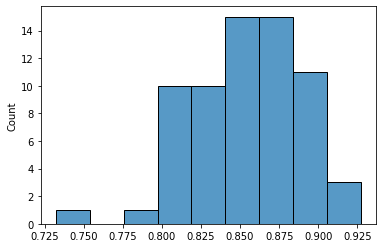

In [15]:
def similarity_to_ideo(corpus, ideo_corpus_index=0):

    sims = gensim.similarities.Similarity(output_prefix = 'workdir/',
                                          corpus=corpus,
                                          num_features=len(full_dictionary))
    ideo_array = corpus[ideo_corpus_index]
    similarity_array = sims[ideo_array]
    
    assert similarity_array[ideo_corpus_index] > 0.99
    return np.delete(similarity_array, ideo_corpus_index)
   
    

bow_sim = similarity_to_ideo(corpus=full_corpus, ideo_corpus_index=ideo_corpus_index)
df_index['similarity_bow'] = bow_sim
fig, ax = plt.subplots()
sns.histplot(bow_sim)
plt.show()

In [16]:
df_index.sort_values(by='similarity_bow', ascending=False)


,titles,dir,similarity_bow
63,orbia_2019_quartzatwork,example_articles,0.927017
26,How I Built Resilience: Varshini Prakash of Su...,how_i_built_this,0.916757
45,How I Built Resilience: Live with Cathy Hughes...,how_i_built_this,0.906958
31,How I Built Resilience: Live with Troy Carter....,how_i_built_this,0.904894
24,How I Built Resilience: Live with Deval Patric...,how_i_built_this,0.898572
...,...,...,...
19,McBride Sisters Wine (Part 1 of 2): Robin McBr...,how_i_built_this,0.801506
55,ClassPass: Payal Kadakia.txt',how_i_built_this,0.799335
8,Khan Academy: Sal Khan.txt',how_i_built_this,0.797939
48,Ring: Jamie Siminoff.txt',how_i_built_this,0.787770


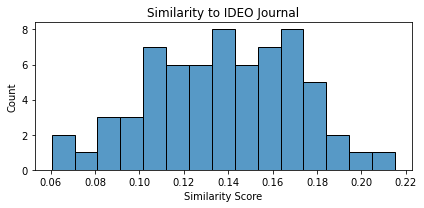

In [17]:
# 
tf_idf = gensim.models.TfidfModel(full_corpus)

# 
tf_idf_sim = similarity_to_ideo(corpus=tf_idf[full_corpus], ideo_corpus_index=ideo_corpus_index)
df_index['similarity_tfidf'] = tf_idf_sim

fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(tf_idf_sim, bins=15)
ax.set_title('Similarity to IDEO Journal')
ax.set_xlabel('Similarity Score')
plt.tight_layout()
plt.savefig('similarity_dist.png')

In [18]:
d = df_index[df_index['dir'] == "example_articles"].sort_values(by='similarity_tfidf', ascending=False)
d.loc[[63, 60, 65, 61, 62], ['titles', 'similarity_tfidf']]

,titles,similarity_tfidf
63,orbia_2019_quartzatwork,0.183726
60,orbia_2019_forbes,0.183207
65,orbia_2018_earnings,0.154980
61,orbia_2019_howtolead,0.104239
62,orbia_2018_reuters_businessnews,0.068656


In [19]:
df = df_index.sort_values(by='similarity_tfidf', ascending=False)

df.set_index('similarity_tfidf')['titles'].head(6)

similarity_tfidf
0.215110    How I Built Resilience: Live with Melanie Perk...
0.199658                          Calendly: Tope Awotona.txt'
0.191772    How I Built Resilience: Sandra Oh Lin of KiwiC...
0.188576                      Kenneth Cole: Kenneth Cole.txt'
0.183726                              orbia_2019_quartzatwork
0.183207                                    orbia_2019_forbes
Name: titles, dtype: object

## Actually pretty bad correlation between similarity scores

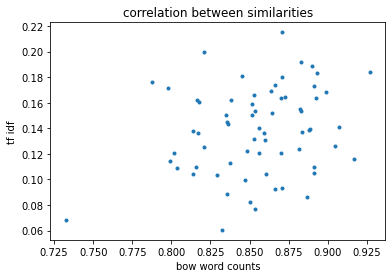

In [23]:
fig, ax = plt.subplots()
ax.plot(df_index['similarity_bow'], df_index['similarity_tfidf'], '.')
# ax.set_xlim(0, 1)
# ax.set_ylim(0,1)
ax.set_ylabel('tf idf')
ax.set_xlabel('bow word counts')
ax.set_title('correlation between similarities')
plt.show()